In [2]:
from field_util import Field, CartCoord

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates.matrix_utilities import rotation_matrix
import numpy as np
from scipy import ndimage
import copy
from matplotlib.colors import LogNorm as LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import os

from matplotlib.backends.backend_pdf import PdfPages

In [20]:
import matplotlib as mpl

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

#cosmetics
mpl.rc('text', usetex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 23
})

In [3]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original

mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)

ra_min = 150.06
ra_max = 150.09

dec_mean = 2.30
dec_min = 2.07
dec_max = 2.50

red_mean = 2.30
red_min = 2.05
red_max = 2.55

x_min = 3750.*u.Mpc # x_0
x_max = 3950.*u.Mpc #x_0 + 438.*u.Mpc

z_min = z_0
z_max = z_0 + 24.*u.Mpc

In [4]:
x_min

<Quantity 3750. Mpc>

In [5]:
cosmo = FlatLambdaCDM(H0=100* u.km / u.s / u.Mpc, Om0=0.315) # Metin original
mycoord = CartCoord(150.14205192829834, 2.224237689411875, cosmo) # Used in Cosmic Birth

data_path = '../Data/'
plot_path = '../Plot/'

In [6]:
R_sm = 4 * u.Mpc

# CLAMATO density field
clamato_path = '../Data/CLAMATO/map_2020_v0.bin'
delta_clm = np.fromfile(clamato_path, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
delta_clm = delta_clm[::1,::-1,::1] 
# this reversal is due to the coordinate in clamato is 
#    x - ra     y - dec
#    0 - 149.89 0 - 2.07
#    68 - 150.4 56 - 2.50  
# consistent with https://github.com/kheegan/preheating2019
x_0, y_0, z_0 = mycoord.orig_to_box(149.89, 2.07, 2.05)
CLAMATO_field = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_clm)
res = CLAMATO_field.smooth(R_sm)


# CLAMATO galaxies
clamato_gal = '../Data/CLAMATO/list_tomo_input_2020_mod.txt'
clm_gal_list = pd.read_csv(clamato_gal, sep = '\t', header = 0)

delta_F_2980_WF = np.fromfile(data_path + "rec_field_sim/pixel_data_RUN11_2980_1_true_SNR.bin_map.bin").reshape(68, 56, 876).transpose(2, 0, 1)[::1, ::-1, ::1]
delta_F_field_WF =Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_F_2980_WF)
res = delta_F_field_WF.smooth(R_sm)

In [7]:
x_0, y_0, z_0

(<Quantity 3629.17159402 Mpc>,
 <Quantity 15.95496184 Mpc>,
 <Quantity -9.76832445 Mpc>)

In [8]:
# reconstruction
# delta_rec_mock = np.fromfile(data_path+"rec_field_sim/pixel_data_RUN11_2980_3_true_SNR.bin_map.bin", dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)
# delta_rec_mock = delta_rec_mock[::1,::-1,::1]


try:
    delta_mock_list = [np.fromfile(data_path+"rec_field_sim/"+fn, dtype='double').reshape(68, 56, 876).transpose(2, 0, 1)[::1, ::-1, ::1]
                        for fn in os.listdir(data_path+"rec_field_sim/") if fn[-3:] == 'bin']
except:
    print(fn)

delta_rec_mock = np.mean(np.array(delta_mock_list), axis = 0)
rec_field_mean = Field(x_0, y_0-34*u.Mpc, z_0, 0.5*u.Mpc, delta_rec_mock)
# res = rec_field.smooth_tophat_fft(R_tophat)
res = rec_field_mean.smooth(R_sm)


x0, y0, z0 = 3550*u.Mpc, -50*u.Mpc, -50*u.Mpc
dl = 2*u.Mpc

# matter
dens_m_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_density.npy")[:, ::-1, :]
opdelta_m_2980 = dens_m_2980 / np.mean(dens_m_2980)
opdelta_m_field = Field(x0, y0, z0, dl, opdelta_m_2980)
# res = opdelta_m_field.smooth_tophat_fft(R_tophat) # 1 + delta_m
res = opdelta_m_field.smooth(R_sm) # 1 + delta_m

# FGPA + RSD
tau_2980 = np.load(data_path+"lores/RUN11_2980_256.00103lowres_tau.npy")[:, ::-1, :]
F_2980 = np.exp(-tau_2980)
delta_F_2980 = F_2980 / np.mean(F_2980) - 1
delta_F_field = Field(x0, y0, z0, dl, delta_F_2980)
# res = delta_F_field.smooth_tophat_fft(R_tophat)
res = delta_F_field.smooth(R_sm)

# WF 2980


In [59]:
RA, DE, red = 150.110, 2.161, 2.298
x_o, y_o, z_o = 1.0*u.Mpc, 0.0*u.Mpc, 244.5*u.Mpc
x_n, y_n, z_n = mycoord.orig_to_box(RA, DE, red)

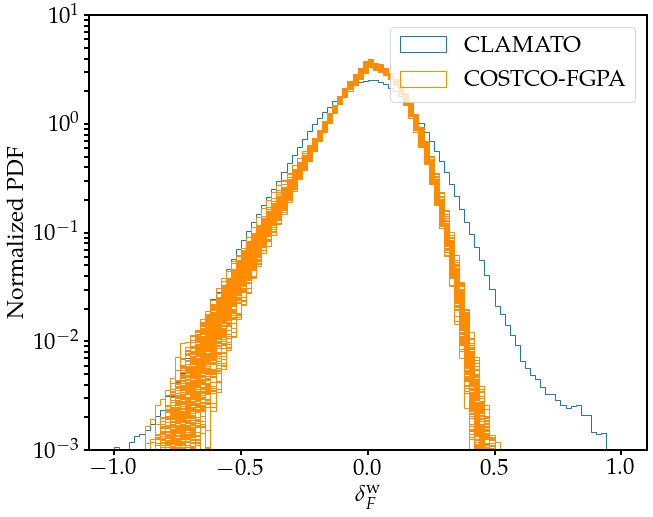

In [11]:
# plt.hist(, density = True, range = (-1, 1), histtype='step', color = )
# no smooth (raw output)
pdf_pages = PdfPages('Global_Hist.pdf')

fig = plt.figure(figsize=(10, 8))
plt.hist([delta_clm.flatten(), ], density = True, range = (-1, 1), histtype='step', label = ['CLAMATO'], bins = 100)
plt.hist(delta_mock_list[0].flatten(), density = True, range = (-1, 1), histtype='step',  color = 'darkorange', bins = 100, label = "COSTCO-FGPA")
[plt.hist(field_data.flatten(), density = True, range = (-1, 1), histtype='step',  color = 'darkorange', bins = 100) for field_data in delta_mock_list[1:]]
plt.yscale('log')
plt.legend()
plt.xlabel("$\\delta_F^{\mathrm{w}}$")
plt.ylabel("Normalized PDF")
plt.ylim(10**-3, 10)

pdf_pages.savefig(fig, pad_inches = 0)
pdf_pages.close()
